# Computed Tomography

In [1]:
import numpy as np
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
from scipy.io import loadmat

The following example is tomographic X-ray data of a walnut. The dataset was prepared by the [Finnish Inverse Problems Society](http://www.fips.fi/dataset.php).

In [2]:
data = loadmat('./data/ct.mat')

The data file contains a measurement matrix $A$ and the projections vector $m$. These are large matrices and so we need sparse matrices.

## Measurement Matrix $A$

Each row of the measurement matrix represents a projection of an X-ray through the sample as a particular angle. The measurement matrix is huge! And so we need to use [sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html) to save memory.

In [3]:
A = data['A']
A.data.nbytes

7762752

In [4]:
A.shape

(9840, 6724)

In [5]:
type(A)

scipy.sparse.csc.csc_matrix

We can visualize each row by reshaping into a matrix. Let's look at the x-ray projection matrix corresponding to random rows of $A$.

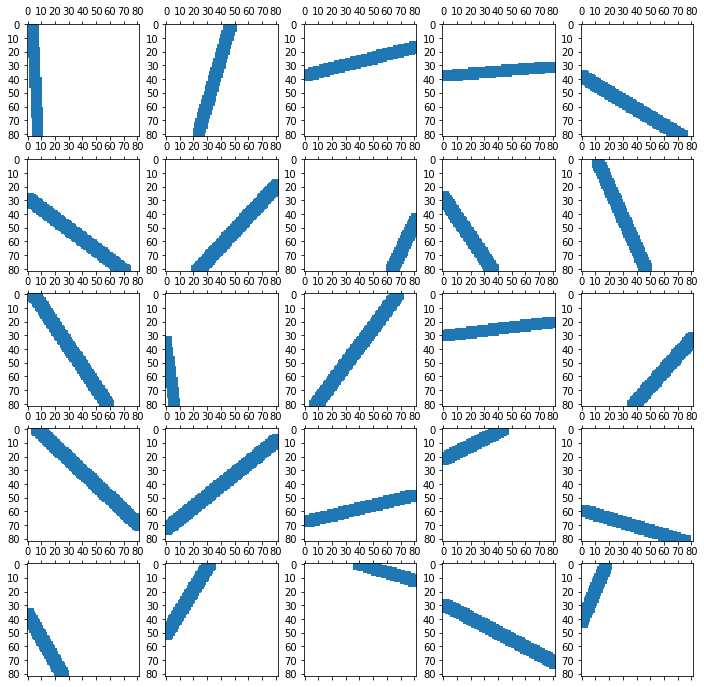

In [6]:
plt.figure(figsize=(12,12))

N = 5
for i in range(0,N**2):
    plt.subplot(N,N,i+1)
    index = np.random.randint(0,A.shape[0])
    proj = A[index,:].reshape(82,82)
    plt.spy(proj)

plt.show()

## Sinogram: Measured Projections

The vector $m$ is the collection of 82 projection measurements from 120 different angles.

In [7]:
sinogram = data['m']

In [8]:
sinogram.nbytes

78720

In [9]:
sinogram.shape

(82, 120)

In [10]:
type(sinogram)

numpy.ndarray

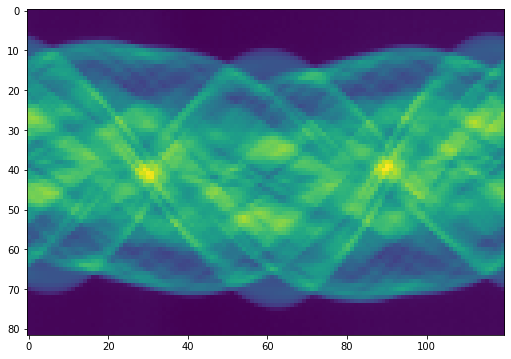

In [11]:
plt.figure(figsize=(10,6))
plt.imshow(sinogram)
plt.show()

## Compute Truncated SVD Solution

We need to solve $A\mathbf{x} = \mathbf{b}$ (where $\mathbf{b}$ is the vector of projections) however there are errors in the projections vector $\mathbf{b}$ and so we actually have

$$
A \hat{\mathbf{x}} = \mathbf{b} + \mathbf{e}
$$

where $\mathbf{e}$ is noise. We need to compute the truncated pseudoinverse to avoid inverting the noise

$$
\hat{\mathbf{x}} = A_k^+ ( \mathbf{b} + \mathbf{e} )
$$

In [12]:
b_e = sinogram.reshape([82*120,1],order='F')

Truncate the measurement matrix after the largest $k$ singular values and compute the pseudoinverse.

In [13]:
k = 200
P,S,QT = sla.svds(A,k=k)

In [14]:
P.shape

(9840, 200)

In [15]:
QT.shape

(200, 6724)

Compute the rank $k$ truncated pseudoinverse $A_k^+$ and $\hat{\mathbf{x}} = A_k^+ ( \mathbf{b} + \mathbf{e} )$

In [16]:
A_k_plus = QT.T @ np.diag(1/S) @ P.T
X = A_k_plus @ b_e

Visualize the result by reshaping $\hat{\mathbf{x}}$ in a square matrix.

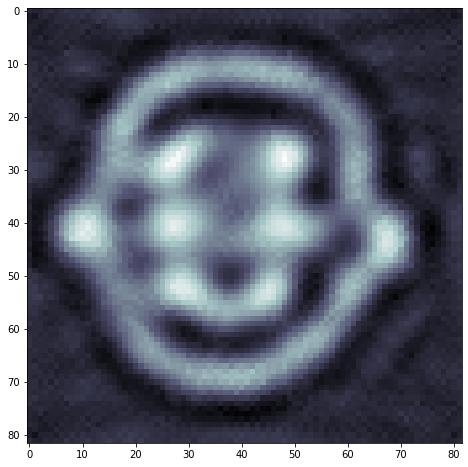

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(X.reshape(82,82).T,cmap='bone')
plt.show()

## True Solution

Compare to the true solution provided by [FIPS](http://www.fips.fi/dataset.php).

![Solution of Computed Tomorgraphy Example](./data/ct_solution.png)